# Experiment 2 - VGG16 on DeepFashion

### Description
* **Dataset**: DeepFashion 'Attribute prediciton', considering only raw images and category information (first ~1000 samples: https://drive.google.com/open?id=0B8Z1YBnBij8sbEY5cXcyd1JTODA). Training, validation and test subsets are predetermined by the dataset itself.

In [1]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Input

import numpy as np
import operator
import pandas as pd

Using TensorFlow backend.


In [2]:
DATASET_PATH = '/home/danfergo/SIG/Code/Experiments/data/deepfashion'
HISTORY_PATH = '/home/danfergo/SIG/Code/Experiments/history/experiment_2.1'
I_SIZE = 150

In [3]:
train_datagen = ImageDataGenerator(
)

validation_datagen = ImageDataGenerator(
)


train_generator = train_datagen.flow_from_directory(
        DATASET_PATH + '/train', 
        target_size=(I_SIZE, I_SIZE),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
        DATASET_PATH + '/validation',
        target_size=(I_SIZE, I_SIZE),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
)

Found 209222 images belonging to 46 classes.
Found 40000 images belonging to 46 classes.


In [4]:
from keras.applications.vgg16 import VGG16
import pickle

input_tensor = (I_SIZE, I_SIZE, 3)
base_model = VGG16(include_top=False, input_shape=input_tensor, weights='imagenet')

x = base_model.output

x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(46, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

pkl_file = open(HISTORY_PATH + '_config.pkl', 'wb')
pickle.dump(model.get_config(), pkl_file)
pkl_file.close()

In [11]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png') 

NameError: name 'model' is not defined

### Training

In [6]:
model.compile(loss='categorical_crossentropy',  optimizer='adadelta', metrics=['accuracy'])

In [ ]:
# (attempts) to load weights from file
try:
    model.load_weights(HISTORY_PATH + '_weights.pkl')
except: 
    pass
    
# train per se
history = model.fit_generator(
        train_generator,
        steps_per_epoch=1000,
        epochs=3,
        validation_data=validation_generator,
        validation_steps=200,
        verbose=1)

# save weights
model.save_weights(HISTORY_PATH + '_weights.pkl')

# (re)save and load history
import pickle

past_history = {}

try: 
    pkl_file = open(HISTORY_PATH + '_history.pkl', 'rb')
    past_history = pickle.load(pkl_file)
    pkl_file.close()
except:
    pass

full_history = {}
    
for k in history.history:
    if k in past_history:
        full_history[k] = np.concatenate((past_history[k], history.history[k]), axis=0)
    else:
        full_history[k] = history.history[k]

pkl_file = open(HISTORY_PATH + '_history.pkl', 'wb')
pickle.dump(full_history, pkl_file)
pkl_file.close()

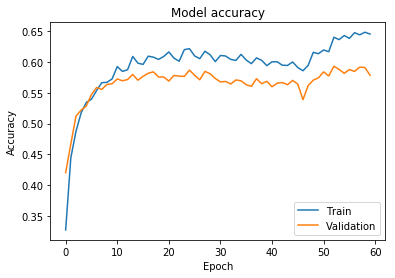

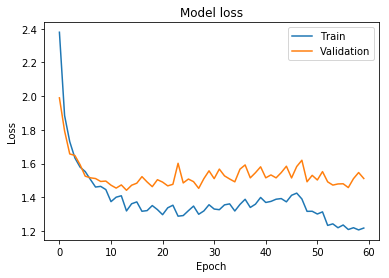

In [9]:
import pickle

pkl_file = open(HISTORY_PATH + '_history.pkl', 'rb')
full_history = pickle.load(pkl_file)
pkl_file.close()

# summarize history for accuracy
plt.plot(full_history['acc'])
plt.plot(full_history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(full_history['loss'])
plt.plot(full_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Evaluation

In [6]:
import pickle 


pkl_file = open(HISTORY_PATH + '_config.pkl', 'rb')
config = pickle.load(pkl_file)
pkl_file.close()

model = Model.from_config(config)
model.compile(loss='categorical_crossentropy',  optimizer='adadelta', metrics=['accuracy'])

model.load_weights(HISTORY_PATH + '_weights.pkl')

In [10]:
test_datagen = ImageDataGenerator(
    # rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
        DATASET_PATH + '/test',
        target_size=(I_SIZE, I_SIZE),
        batch_size=2000,
        class_mode='categorical'
)

Found 40000 images belonging to 46 classes.


In [ ]:
x_test, y_test = test_generator.next()

y_pred = model.predict(x_test, batch_size=2000)

In [ ]:
class_indices = validation_generator.class_indices
sorted_class_indices = sorted(class_indices.items(), key=operator.itemgetter(1))
target_names = [x[0] for x in sorted_class_indices]

labels = range(0, len(target_names))
conf = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels)
pd.DataFrame(data = conf, index=target_names, columns=target_names)

### Results



In [ ]:
# input_tensor = Input(shape=(299, 299, 3))
# model = ResNet50(include_top=True, input_tensor=input_tensor, weights=None, classes=9)

# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt

# sm = plt.imshow(mpimg.imread('model.png'))

# model = Sequential()
# model.add(base_model)

# module named 'keras.utils.visualize_util'


# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))